In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('./nus-fintech-society-project-1/data.csv', sep=",", parse_dates=[0])

# Checking to see if dataset is properly fetched
df.head()

,Date,Open,High,Low,Close,Volume
0,2010-09-13,15400,15519,15320,15400,234851
1,2010-09-14,15500,15620,15200,15200,371530
2,2010-09-15,15260,15340,15020,15140,389289
3,2010-09-16,15080,15260,15080,15140,234815
4,2010-09-17,15240,15560,15159,15460,447649


## Using Autoregressive (AR) Model for Predictions

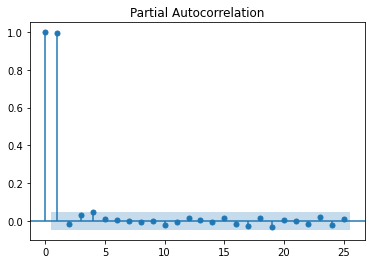

In [4]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

# We plot the partial autocorrection plot to determine the order of the AR model
pacf = plot_pacf(df['Close'], lags=25)

In [5]:
# We split the data using a 70-30 train-test split
train_data = df['Close'][:int(len(df)*0.7)]
test_data = df['Close'][int(len(df)*0.7):]

# We train the AR model of order 1, since other correlation values are not high enough
ar_model = AutoReg(train_data, lags=1).fit()
pred = ar_model.predict(start=len(train_data), end=(len(df)-1), dynamic=False)

# Calculating the mean squared error, to determine how accurate the model is
MSE_error = mean_squared_error(test_data, pred)
print('Mean Squared Error is ' + str(MSE_error))

Mean Squared Error is 38213892.4792195


#### Conclusion: From this, we can infer that using an AR model is not suitable for this.

## Using Moving Average (MA) for Predictions

In [7]:
# We create a dataframe with only the dates and closing prices
new_data = pd.DataFrame(df, columns=['Date', 'Close'])

# We split the data using a 70-30 train-test split
train_data = new_data[:int(len(new_data)*0.7)]
test_data = new_data[int(len(new_data)*0.7):]

# We then make predictions according to the previously observed values
predictions = []
for count in range(0, test_data.shape[0]):
    a = train_data['Close'][len(train_data) - len(test_data) + count:].sum() + sum(predictions)
    b = a/len(test_data)
    predictions.append(b)
    
# Calculating the mean squared error, to determine how accurate the method is
MSE_error = np.sqrt(np.mean(np.power((np.array(test_data['Close']) - predictions), 2)))
print('Mean Squared Error is ' + str(MSE_error))

Mean Squared Error is 5981.611180624054


#### Conclusion: From this, we can infer that it is much more suitable to use Moving Average (MA) to predict the 'Close' prices in this case, as compared to Autoregression

## Using auto Autoregressive Integrated Moving Average (ARIMA) model for Predictions

We use auto ARIMA model, instead of the normal ARIMA model, so as to allow for automatic selection
of parameters that provides the least error in the predictions

In [7]:
from pmdarima.arima import auto_arima

# We split the data using a 70-30 train-test split
train_data = df[:int(len(df)*0.7)]
test_data = df[int(len(df)*0.7):]

# We extract the closing prices of both training and testing datasets
train_close = train_data['Close']
test_close = test_data['Close']

# We build the auto ARIMA model and fit the model to the training data
model = auto_arima(train_close, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(train_close)

# We then use the auto ARIMA model to help us come up with the predictions for the closing price
predictions = model.predict(n_periods=len(test_close))
predictions = pd.DataFrame(predictions,index = test_data.index,columns=['Prediction'])

# Calculating the mean squared error, to determine how accurate the model is
MSE_error = np.sqrt(np.mean(np.power((np.array(test_data['Close'])-np.array(predictions['Prediction'])),2)))
print('Mean Squared Error is ' + str(MSE_error))

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.09 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=17567.160, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=17261.226, Time=0.42 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=17564.102, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=17123.652, Time=1.41 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.48 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.30 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=17122.977, Time=0.32 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=17261.020, Time=0.14 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.17 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.96 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=17123.474, Time=1.23 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=2.64 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=1712

#### Conclusion: From this, we can infer that using an auto ARIMA model is definitely much better than using an AR model to help us predict the closing prices. However, it is unclear if it is more suitable to use the MA approach or the auto ARIMA approach in this case, since the difference in MSE is not substantial.

## Coming up with predictions for 'sample_submission.csv'

Since the MA approach is giving us the most accurate predictions with the least mean squared error, we shall use the MA approach to help us come up with the final predictions.

In [9]:
submission_df = pd.read_csv('./nus-fintech-society-project-1/sample_submission.csv', sep=",", parse_dates=[0])
submission_df.head()

,Date,Predicted
0,2017-04-13,0
1,2017-04-14,0
2,2017-04-17,0
3,2017-04-18,0
4,2017-04-19,0


In [10]:
# We first use the MA approach to come up with the predicted closing prices
new_data = pd.DataFrame(df, columns=['Date', 'Close'])
predictions_ma = []
for count in range(0, submission_df.shape[0]):
    a = new_data['Close'][len(new_data) - len(submission_df) + count:].sum() + sum(predictions_ma)
    b = a/len(submission_df)
    predictions_ma.append(b)

In [11]:
# Obtaining the predictions using MA
submission_df['Predicted'] = np.array(predictions_ma)

# Normalizing the values to the Closing Price of the last day in the given dataset
submission_df['Predicted'] += df['Close'][len(df) - 1] - np.array(predictions_ma)[0]

# We write the DataFrame containing the predicted values to a csv file
submission_df.to_csv('submission_v1.csv', index=False)